Question-1 : Support Vector Machine and Perceptron

Preprocessing 

In [ ]:
import Oracle_Assignment_2
import numpy as np 
import matplotlib.pyplot as plt
plt.style.use('default')
train_data,test_data = Oracle_Assignment_2.q1_get_cifar100_train_test(23627)
train_features,train_labels = [],[]
test_features,test_labels = [],[]
for x in train_data:
    train_features.append(x[0])
    train_labels.append(x[1])
train_features = np.array(train_features)
train_labels = np.array(train_labels) # -1 and 1 
for x in test_data:
    test_features.append(x[0])
    test_labels.append(x[1])
test_features = np.array(test_features)
test_labels = np.array(test_labels)
train_mean = np.mean(train_features, axis=0) 
train_std = np.std(train_features, axis=0)   
# print(train_features.shape,train_labels.shape) # Returns : (1000,27) (1000,)
# print(test_features.shape,test_labels.shape) # Returns : (200,27) (200,)

Task : Run the perceptron algorithm on your data. Report whether it converges, or appears
not to. If it doesn’t seem to converge, make certain that you are reasonably sure.

Question : A plot between misclassification rate and number of iterations for the perceptron algorithm as defined
in Task 1.

Did not converge


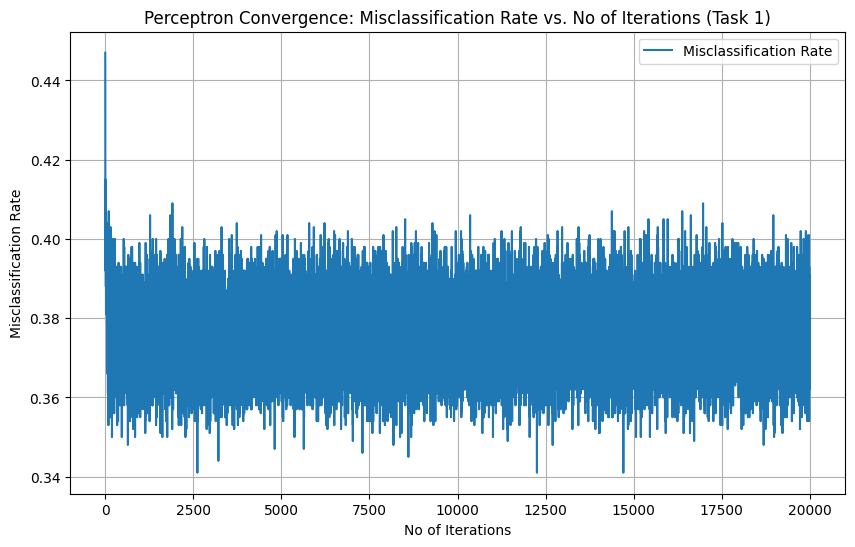

In [ ]:
def Perceptron(train_features,train_labels,max_iterations = 20000):
    d = len(train_features[0])
    w = [0.0 for i in range(d)]
    b = 0.0
    misclassification_rates = []
    converged = False
    for t in range(max_iterations):
        misclassified = 0
        for i in range(len(train_features)):
            x = train_features[i]
            y = train_labels[i]
            dot_product = sum([w[j]*x[j] for j in range(d)]) # calculating wT.x
            predicted_label = dot_product + b 
            if predicted_label*y <= 0:
                misclassified += 1
                for j in range(d):
                    w[j] += y*x[j]
                b += y
        misclassification_rate = misclassified/len(train_features)
        misclassification_rates.append(misclassification_rate)
        if misclassified == 0:
            converged = True
            print(f"Converged after {t+1} iterations")
            break
    else:
        print("Did not converge")
    return w,b,misclassification_rates,converged 
w,b,misclassification_rates,converged = Perceptron(train_features,train_labels)
iterations = list(range(1, len(misclassification_rates) + 1))
plt.figure(figsize=(10, 6))
plt.plot(iterations, misclassification_rates, label="Misclassification Rate")
plt.xlabel("No of Iterations")
plt.ylabel("Misclassification Rate")
plt.title("Perceptron Convergence: Misclassification Rate vs. No of Iterations (Task 1)")
plt.grid(True)
plt.legend()
plt.show()

Task : Linear SVM; Construct a slack support vector machine with the linear kernel. Solve both the primal
and dual versions of the SVM quadratic programs using cvxopt. Use the SVM’s solution to isolate
the sources of non-separability

Question-1: Which, between the primal and dual, is solved faster for Task 2. Report the times taken for running
both, and justify any patterns you see.

Question-2 : Give the indicies which are causing inseparability in the data in a csv file of name inseperable_{sr_number}.csv
Primal SVM :
1. The primal SVM is solved using the cvxopt library.    
2. Returns w,b,xi(slack variables) and time_taken 

Dual SVM :

1. The dual SVM is solved using the cvxopt library.
2. Returns w,b,alphas (Lagrange Multipliers for inequality constraints) and time_taken

In [ ]:
import numpy as np 
import cvxopt 
import time 

class SVM:
    def __init__(self, regularization_parameter=1.0):
        self.C = regularization_parameter  # Regularization parameter (tradeoff between maximizing margin and minimizing slack)
        self.w_primal = None
        self.b_primal = None
        self.slack_values = None
        self.alpha_dual = None
        self.w_dual = None
        self.b_dual = None
        self.primal_time = None
        self.dual_time = None
    def Primal_SVM(self,X,y):
        num_samples, num_features = len(X), len(X[0])
        variable_size = num_features + 1 + num_samples
        P = [[0.0 for _ in range(variable_size)] for _ in range(variable_size)]
        for i in range(num_features):  # For ||w||^2 term
            P[i][i] = 1.0
        q = [0.0 for _ in range(variable_size)]
        q[num_features + 1:] = [float(self.C) for _ in range(num_samples)] # For slack variables
        # Inequality constraints G and h 
        G = np.zeros((2*num_samples, variable_size))
        h = np.zeros(2*num_samples)
        # Constraint 1: y_i (w^T x_i + b) >= 1 - ξ_i
        for i in range(num_samples):
            G[i, :num_features] = -y[i] * X[i]
            G[i, num_features] = -y[i]
            G[i, num_features + 1 + i] = -1
            h[i] = -1
        # Constraint 2: ξ_i >= 0
        for i in range(num_samples):
            G[num_samples + i, num_features + 1 + i] = -1
            h[num_samples + i] = 0
        # Convert to cvxopt format
        P = cvxopt.matrix(P)
        q = cvxopt.matrix(q)
        G = cvxopt.matrix(G)
        h = cvxopt.matrix(h)
        # Solve the QP problem and Measure time taken to solve the primal SVM
        cvxopt.solvers.options['show_progress'] = False
        start_time = time.time()
        solution = cvxopt.solvers.qp(P, q, G, h)
        self.primal_time = time.time() - start_time
        # Extract solution
        primal_solution = np.array(solution['x']).flatten()
        self.w_primal = primal_solution[:num_features]
        self.b_primal = primal_solution[num_features]
        self.slack_values = primal_solution[num_features + 1:]

        # Identify non-separable points (ξ_i > 1)
        non_separable_indices = [] # ξ_i > 1 which implies y_i (w^T x_i + b) < 0
        for i in range(num_samples):
            if self.slack_values[i] > 1:
                non_separable_indices.append(i)
        return self.w_primal, self.b_primal, self.slack_values, non_separable_indices
    def Dual_SVM(self,X,y):
        num_samples = len(X)

        # Compute the kernel matrix (linear kernel: K[i,j] = x_i^T x_j)
        K = [[0.0 for _ in range(num_samples)] for _ in range(num_samples)]
        for i in range(num_samples):
            for j in range(num_samples):
                K[i][j] = sum(X[i][k] * X[j][k] for k in range(len(X[0])))
        # compute P = (y_i * y_j * K_ij)
        P = [[0.0 for _ in range(num_samples)] for _ in range(num_samples)]
        for i in range(num_samples):
            for j in range(num_samples):
                P[i][j] = y[i] * y[j] * K[i][j]
        q = [-1.0 for _ in range(num_samples)]
        # Box constraints: 0 < alpha_i < C
        G = np.vstack((-np.eye(num_samples), np.eye(num_samples)))
        h = np.hstack((np.zeros(num_samples), self.C * np.ones(num_samples)))
        # Equality constraint: A and b
        A = y.reshape(1, -1)
        b = 0.0

        # Convert to cvxopt format
        P = cvxopt.matrix(P)
        q = cvxopt.matrix(q)
        G = cvxopt.matrix(G)
        h = cvxopt.matrix(h)
        A = cvxopt.matrix(A, (1, num_samples), 'd')
        b = cvxopt.matrix(b)

        # Solve the QP problem and measure time
        cvxopt.solvers.options['show_progress'] = False
        start_time = time.time()
        solution = cvxopt.solvers.qp(P, q, G, h, A, b)
        self.dual_time = time.time() - start_time

        # Extract dual variables (alpha_i)
        self.alpha_dual = np.array(solution['x']).flatten()

        # Compute w and b
        self.w_dual = np.sum((self.alpha_dual * y).reshape(-1, 1) * X, axis=0)
        support_vector_indices = [i for i in range(num_samples) if 1e-5 < self.alpha_dual[i] < self.C - 1e-5]
        if len(support_vector_indices)!=0:
            self.b_dual = np.mean(y[support_vector_indices] - np.dot(X[support_vector_indices], self.w_dual))
        else:
            self.b_dual = 0

        # Identify misclassified (non-separable) points
        predictions = np.sign(np.dot(X, self.w_dual) + self.b_dual)
        non_separable_indices = [] # y_i (w^T x_i + b) < 0
        for i in range(num_samples):
            if predictions[i] != y[i]:
                non_separable_indices.append(i)
        return self.w_dual, self.b_dual, self.alpha_dual, non_separable_indices
    def Compare_solutions(self):
        print(f"Primal SVM Time: {self.primal_time:.4f} seconds")
        print(f"Dual SVM Time: {self.dual_time:.4f} seconds")
        w_diff = np.linalg.norm(self.w_primal - self.w_dual)
        b_diff = abs(self.b_primal - self.b_dual)
        print(f"Difference in w (L2 norm): {w_diff:.3f}")
        print(f"Difference in b: {b_diff:.3f}")
    def save_non_seperable_indices(self,indices,sr_number):
        file_name = f"inseparable_{sr_number}.csv"
        np.savetxt(file_name,indices,delimiter=",",fmt = "%d")
        print(f"Indices of non-separable points saved to {file_name}")
    
svm = SVM(regularization_parameter=1.0)
w_primal, b_primal, slack_values, primal_non_separable_indices = svm.Primal_SVM(train_features, train_labels)
w_dual, b_dual, alpha_dual, dual_non_separable_indices = svm.Dual_SVM(train_features, train_labels)
print("Primal SVM Results:")
print(f"Number of points with ξ_i > 1: {len(primal_non_separable_indices)}")
print(f"Indices of non-separable points (primal): {primal_non_separable_indices}")
print("\nDual SVM Results:")
print(f"Number of misclassified points: {len(dual_non_separable_indices)}")
print(f"Indices of non-separable points (dual): {dual_non_separable_indices}")
svm.Compare_solutions()
svm.save_non_seperable_indices(primal_non_separable_indices,23627)

Primal SVM Results:
Number of points with ξ_i > 1: 281
Indices of non-separable points (primal): [0, 1, 5, 8, 12, 20, 23, 24, 25, 26, 27, 28, 30, 35, 37, 39, 40, 42, 44, 45, 51, 52, 56, 78, 82, 86, 87, 89, 94, 95, 96, 98, 99, 102, 106, 108, 110, 112, 115, 116, 118, 123, 128, 134, 143, 150, 151, 152, 153, 154, 156, 159, 165, 169, 174, 183, 188, 190, 191, 195, 207, 209, 213, 217, 220, 221, 225, 227, 230, 237, 246, 251, 253, 257, 259, 260, 262, 265, 267, 271, 278, 284, 285, 286, 288, 297, 300, 304, 312, 314, 316, 317, 323, 328, 336, 338, 345, 355, 358, 359, 360, 363, 372, 375, 380, 384, 388, 395, 397, 398, 402, 404, 410, 416, 419, 421, 428, 431, 432, 435, 436, 438, 440, 441, 443, 449, 450, 451, 454, 455, 456, 457, 465, 468, 470, 475, 485, 487, 489, 493, 495, 499, 506, 509, 516, 517, 521, 526, 530, 533, 537, 541, 547, 551, 554, 558, 560, 565, 566, 567, 570, 573, 577, 580, 586, 588, 596, 602, 604, 605, 607, 608, 611, 612, 613, 617, 620, 636, 639, 648, 650, 660, 661, 663, 666, 667, 671, 674,

Task : Kernelized SVM; Repeat the previous construction, but with the Gaussian kernel this time. Choose
your hyperparameters such that non-separability is no longer an issue, and your decision boundary is
consistent with the training data’s labels.

Question : The final misclassification rate for the kernelized SVM for Task 3.

In [ ]:
import numpy as np
from cvxopt import matrix, solvers

class Gaussian_Kernel_SVM:
    def __init__(self, C, gamma):
        self.C = C              # Regularization parameter
        self.gamma = gamma      # Gaussian kernel parameter
        self.alphas = None      # Lagrange multipliers
        self.b = None           # Bias term
        self.X_train = None     # Training features
        self.y_train = None     # Training labels
        self.support_vectors = None  # Support vectors
        self.support_indices = None  # Indices of support vectors

    def Gaussian_kernel(self, x1, x2):
        diff = x1 - x2
        return np.exp(-self.gamma * np.dot(diff, diff))

    def Kernel_matrix(self, X):
        n = X.shape[0]
        K = np.zeros((n, n))
        for i in range(n):
            for j in range(n):
                K[i, j] = self.Gaussian_kernel(X[i], X[j])
        return K

    def Dual_SVM(self, X, y):
        self.X_train = X
        self.y_train = y
        n = X.shape[0]

        # Compute kernel matrix
        K = self.Kernel_matrix(X)

        # Set up quadratic programming problem
        P = matrix(np.outer(y, y) * K)          # Kernel matrix scaled by labels
        q = matrix(-np.ones(n))                 # Linear term
        G = matrix(np.vstack((-np.eye(n), np.eye(n))))  # Inequality constraints
        h = matrix(np.hstack((np.zeros(n), self.C * np.ones(n))))  
        A = matrix(y, (1, n), 'd')              # Equality constraint (sum alpha_i y_i = 0)
        b = matrix(0.0)                         

        # Solve the QP problem
        solvers.options['show_progress'] = False
        solution = solvers.qp(P, q, G, h, A, b)
        self.alphas = np.array(solution['x']).flatten()

        # Identify support vectors (alpha_i > threshold)
        self.support_indices = np.where(self.alphas > 1e-5)[0]
        self.support_vectors = X[self.support_indices]

        # Compute bias term using a support vector
        for i in self.support_indices:
            if self.alphas[i] < self.C - 1e-5:
                self.b = y[i] - np.sum(self.alphas[self.support_indices] * y[self.support_indices] * K[self.support_indices, i])
                break
        else:
            self.b = 0  # Fallback if no suitable support vector found
        return self.alphas, self.b

    def predict(self, X_test):
        predictions = []
        for x in X_test:
            kernel_values = np.array([self.Gaussian_kernel(x, sv) for sv in self.support_vectors])
            decision = np.sum(self.alphas[self.support_indices] * self.y_train[self.support_indices] * kernel_values) + self.b
            predictions.append(np.sign(decision))
        return np.array(predictions)

    def misclassification_rate(self, X, y):
        predictions = self.predict(X)
        errors = np.sum(predictions != y)
        return (errors / len(y)) * 100
    
svm = Gaussian_Kernel_SVM(C=1.0, gamma=999)
svm.Dual_SVM(train_features, train_labels)
train_misclassification = svm.misclassification_rate(train_features, train_labels)
print(f"Training misclassification rate: {train_misclassification:.2f}%")
print(f"Optimized Hyper parameters for 0 misclassification rate: C = 1.0, gamma = 999")

Task : Perceptron, again; Retrain the perceptron, after removing the sources of non-separability isolated
by the linear SVM. Verify that it converges

Question : A plot between misclassification rate and iterations for the perceptron for Task 4.

Points to remove: 281 
Modified dataset: 719 points
Converged after 296 iterations
Perceptron converged
Final misclassification rate: 0.0000


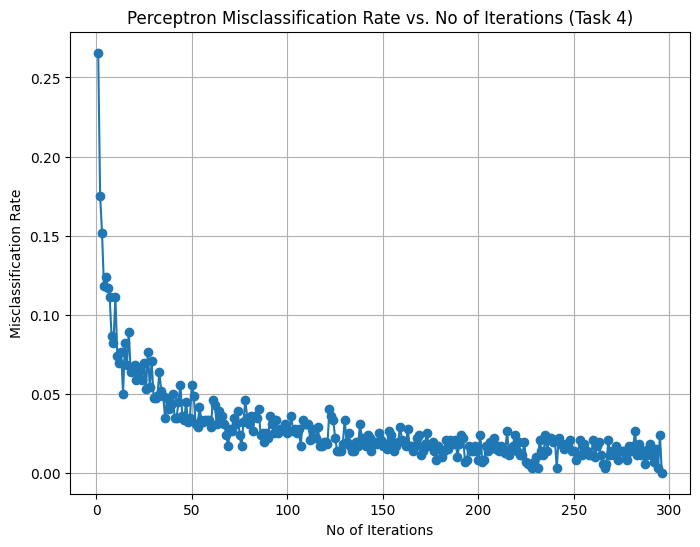

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
svm = SVM(regularization_parameter=1.0)
def Task_4(X, y, C=1.0):
    # Identify the points causing inseparability using the primal solution
    w_primal, b_primal, slack_values, primal_non_separable_indices = svm.Primal_SVM(X, y)
    points_to_remove = X[primal_non_separable_indices]
    print(f"Points to remove: {len(points_to_remove)} ")
    mask = np.ones(len(X), dtype=bool)
    mask[primal_non_separable_indices] = False
    X_modified, y_modified = X[mask], y[mask]
    print(f"Modified dataset: {len(X_modified)} points")
    w, b, misclassification_rates, converged = Perceptron(X_modified, y_modified)
    if converged:
        print("Perceptron converged")
    else:
        print("Perceptron did not converge within max_iterations")
    print(f"Final misclassification rate: {misclassification_rates[-1]:.4f}")
    # Plot
    plt.figure(figsize=(8, 6))
    plt.plot(range(1, len(misclassification_rates) + 1), misclassification_rates, marker='o', linestyle='-')
    plt.xlabel('No of Iterations')
    plt.ylabel('Misclassification Rate')
    plt.title('Perceptron Misclassification Rate vs. No of Iterations (Task 4)')
    plt.grid(True)
    plt.show()

X, y = train_features, train_labels
Task_4(X, y, C=1.0)